<a href="https://colab.research.google.com/github/jraval/LambdaSchoolDataScience/blob/master/JRCopy_of_DSPT10_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [224]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [225]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23040 entries, 0 to 23039
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         23040 non-null  int64  
 1   NEIGHBORHOOD                    23040 non-null  object 
 2   BUILDING_CLASS_CATEGORY         23040 non-null  object 
 3   TAX_CLASS_AT_PRESENT            23039 non-null  object 
 4   BLOCK                           23040 non-null  int64  
 5   LOT                             23040 non-null  int64  
 6   EASE-MENT                       0 non-null      float64
 7   BUILDING_CLASS_AT_PRESENT       23039 non-null  object 
 8   ADDRESS                         23040 non-null  object 
 9   APARTMENT_NUMBER                5201 non-null   object 
 10  ZIP_CODE                        23039 non-null  float64
 11  RESIDENTIAL_UNITS               23039 non-null  float64
 12  COMMERCIAL_UNITS                

In [227]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [228]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [229]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [230]:
df_subset = (df[df['BUILDING_CLASS_CATEGORY'].isin(['01 ONE FAMILY DWELLINGS'])])

In [231]:
#df_subset = df_subset.copy

In [232]:
#df_2 = (df_subset['SALE_PRICE'] > 100000) & (df_subset['SALE_PRICE'] < 2000000 )
#(df['two'] >= -0.5) & (df['two'] < 0.5)

In [233]:
df_subset_final = df_subset[df_subset['SALE_PRICE'] > 100000]
#Final Subset is df_2 with all other conditions included, there's probably a more efficient method at doing this - Obstacle 1
df_2 =  df_subset_final[df_subset_final['SALE_PRICE'] < 2000000]

In [234]:
df_2 = df_2.copy()

In [235]:
df_2.sort_values(by='SALE_PRICE', ascending=True)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18147,4,OTHER,01 ONE FAMILY DWELLINGS,1,11159,11,NaN,A0,223-29 103RD AVENUE,NaN,11429.0,1.0,0.0,1.0,"3,910",1163.0,1950.0,1,A0,104000,03/30/2019
3489,4,OTHER,01 ONE FAMILY DWELLINGS,1,16118,56,NaN,A5,313 BEACH 86 STREET,NaN,11693.0,1.0,0.0,1.0,"1,802",1205.0,1920.0,1,A5,105000,01/18/2019
19961,5,OTHER,01 ONE FAMILY DWELLINGS,1,1087,14,NaN,A1,147 HARRISON AVENUE,NaN,10302.0,1.0,0.0,1.0,"2,525",1336.0,1899.0,1,A1,107500,04/09/2019
791,2,OTHER,01 ONE FAMILY DWELLINGS,1,3992,55,NaN,A2,2425 ST. RAYMONDS AVENUE,NaN,10461.0,1.0,0.0,1.0,"3,590",1400.0,1925.0,1,A2,108000,01/07/2019
15768,2,OTHER,01 ONE FAMILY DWELLINGS,1D,5514,62,NaN,A8,"81D EDGEWATER PARK, 81D",NaN,10465.0,0.0,0.0,0.0,0,0.0,1930.0,1,A8,110000,03/20/2019
18668,5,OTHER,01 ONE FAMILY DWELLINGS,1,3412,49,NaN,A6,84 MC LAUGHLIN STREET,NaN,10305.0,1.0,0.0,1.0,"2,000",280.0,1925.0,1,A6,110000,04/02/2019
2313,4,OTHER,01 ONE FAMILY DWELLINGS,1,16118,47,NaN,A5,335 BEACH 86 STREET,NaN,11693.0,1.0,0.0,1.0,"2,002",1476.0,1920.0,1,A5,112000,01/14/2019
4221,4,OTHER,01 ONE FAMILY DWELLINGS,1,12607,26,NaN,A1,11834 192 STREET,NaN,11412.0,1.0,0.0,1.0,"4,000",1508.0,1925.0,1,A1,112000,01/23/2019
11279,5,OTHER,01 ONE FAMILY DWELLINGS,1,5659,32,NaN,A1,55 WOLCOTT AVENUE,NaN,10312.0,1.0,0.0,1.0,"4,000",1200.0,1940.0,1,A1,113348,02/26/2019
2913,4,OTHER,01 ONE FAMILY DWELLINGS,1,11192,48,NaN,A0,108-16 227 STREET,NaN,11429.0,1.0,0.0,1.0,"3,600",1206.0,1950.0,1,A0,114000,01/16/2019


In [236]:
df_2['SALE_DATE'] = pd.to_datetime(df_2['SALE_DATE'], infer_datetime_format=True)
cutoff = pd.to_datetime('04/01/2019')
mask = df_2['SALE_DATE'] < cutoff
mask.head()

44     True
61     True
78     True
108    True
111    True
Name: SALE_DATE, dtype: bool

In [237]:
train = df_2.loc[mask]
train.shape

(2507, 21)

In [238]:
test = df_2.loc[~mask]
test.shape

(644, 21)

In [239]:
df_2.isnull().values.any()

True

In [240]:
df_2.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02


In [241]:
pd.set_option('display.max_rows', None)#Can't see anything with rows limited

In [242]:
'''
cutoff = pd.to_datetime('04/01/2019')
train = df_2[df_2.SALE_DATE < cutoff]
test  = df_2[df_2.SALE_DATE >= cutoff]
'''

"\ncutoff = pd.to_datetime('04/01/2019')\ntrain = df_2[df_2.SALE_DATE < cutoff]\ntest  = df_2[df_2.SALE_DATE >= cutoff]\n"

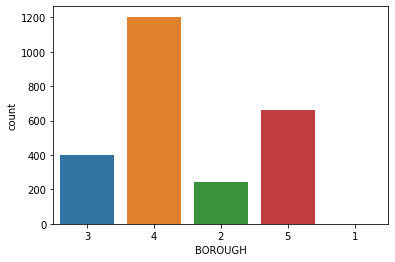

In [243]:
#Had a little trouble with this too, could not find a feature with low cardinality

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#data = train['BUILDING_CLASS_AT_PRESENT']
#x = 'SALE_PRICE'
sns.countplot(x='BOROUGH', data=train);

In [284]:
#Finally chose low cardinality features after numerous trial and error periods
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'ZIP_CODE','SALE_DATE','LAND_SQUARE_FEET',
'BUILDING_CLASS_CATEGORY', 'BLOCK','LOT', 'EASE-MENT', 
'BUILDING_CLASS_AT_PRESENT', 'APARTMENT_NUMBER', 'RESIDENTIAL_UNITS', 
'COMMERCIAL_UNITS', 'TOTAL_UNITS','GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
'BUILDING_CLASS_AT_TIME_OF_SALE']

features = train.columns.drop([target] + high_cardinality)

features

Index(['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT'], dtype='object')

In [283]:
# TODO
train['TAX_CLASS_AT_PRESENT'].value_counts()

1     2476
1D      31
Name: TAX_CLASS_AT_PRESENT, dtype: int64

In [257]:
train['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts()

A1    919
A5    779
A2    413
A9    193
A0     67
S1     39
A3     38
A8     31
A6     14
A4     13
S0      1
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

In [285]:
train.shape, test.shape

((2507, 21), (644, 21))

In [286]:
train.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [287]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2507, 3), (644, 3), (2507,), (644,))

In [288]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [289]:
X_train.shape#Features added, went from 3 to 14 Easment column with NaNs was also dropped without having to drop or fill NaNs/null values

(2507, 14)

In [290]:
X_train.head(20)

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D
44,1,0,0,0,0,1,0,0,0,0,0,0,1,0
61,0,1,0,0,0,1,0,0,0,0,0,0,1,0
78,0,0,1,0,0,1,0,0,0,0,0,0,1,0
108,1,0,0,0,0,1,0,0,0,0,0,0,1,0
111,1,0,0,0,0,1,0,0,0,0,0,0,1,0
120,1,0,0,0,0,1,0,0,0,0,0,0,1,0
121,1,0,0,0,0,1,0,0,0,0,0,0,1,0
132,0,1,0,0,0,1,0,0,0,0,0,0,1,0
137,0,1,0,0,0,1,0,0,0,0,0,0,1,0
141,0,1,0,0,0,0,1,0,0,0,0,0,1,0


In [291]:
X_train.dtypes

BOROUGH_3                          int64
BOROUGH_4                          int64
BOROUGH_2                          int64
BOROUGH_5                          int64
BOROUGH_1                          int64
NEIGHBORHOOD_OTHER                 int64
NEIGHBORHOOD_FLUSHING-NORTH        int64
NEIGHBORHOOD_EAST NEW YORK         int64
NEIGHBORHOOD_BEDFORD STUYVESANT    int64
NEIGHBORHOOD_FOREST HILLS          int64
NEIGHBORHOOD_BOROUGH PARK          int64
NEIGHBORHOOD_ASTORIA               int64
TAX_CLASS_AT_PRESENT_1             int64
TAX_CLASS_AT_PRESENT_1D            int64
dtype: object

In [292]:
# How many features do we have currently?
features = X_train.columns
n = len(features)
n

14

In [325]:
# TODO: Select the 15 features that best correlate with the target
# (15 is an arbitrary starting point here)
# I chose 10
# SelectKBest has a similar API to what we've seen before.
# IMPORTANT!
# .fit_transform on the train set
# .transform on test set

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(k = 10)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [326]:
# TODO: Which features were selected?

selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH_3
BOROUGH_4
BOROUGH_5
BOROUGH_1
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D


Features not selected:
BOROUGH_2
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_BEDFORD STUYVESANT


In [328]:
# TODO: How many features should be selected?

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

# You can try a range of values for k,
# then choose the model with the best score.
# If multiple models "tie" for the best score,
# choose the simplest model.
# You decide what counts as a tie!

1 features
Test Mean Absolute Error: $212,604 

2 features
Test Mean Absolute Error: $207,495 

3 features
Test Mean Absolute Error: $207,485 

4 features
Test Mean Absolute Error: $206,591 

5 features
Test Mean Absolute Error: $205,240 

6 features
Test Mean Absolute Error: $204,707 

7 features
Test Mean Absolute Error: $201,294 

8 features
Test Mean Absolute Error: $201,287 

9 features
Test Mean Absolute Error: $198,801 

10 features
Test Mean Absolute Error: $198,801 

11 features
Test Mean Absolute Error: $199,216 

12 features
Test Mean Absolute Error: $199,226 

13 features
Test Mean Absolute Error: $199,455 

14 features
Test Mean Absolute Error: $199,631 



In [324]:
from sklearn.metrics import r2_score
print('Training R-squared:', r2_score(y_train, model.predict(X_train)))
print('Test R-squared:', r2_score(y_test, model.predict(X_test)))

Training R-squared: 0.1666478013173125
Test R-squared: 0.12450008428360626


In [213]:
train['BOROUGH_4'] = X_train['BOROUGH_4']#This is not the same as above, but I just wanted to add a data visualization.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


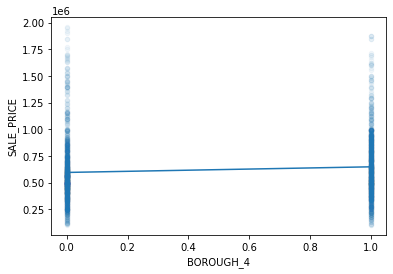

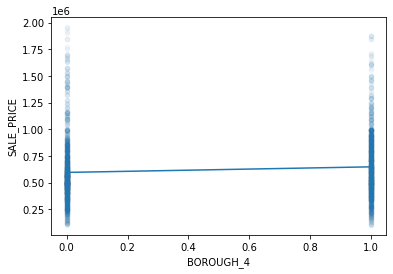

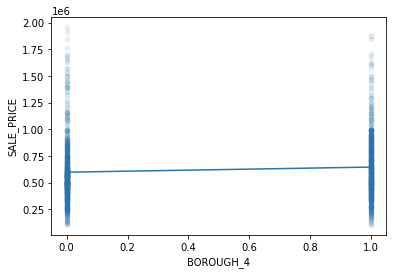

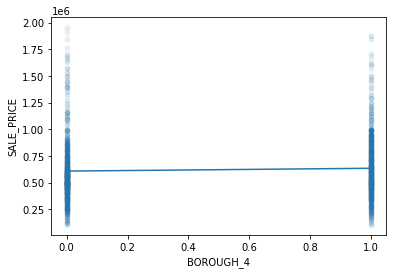

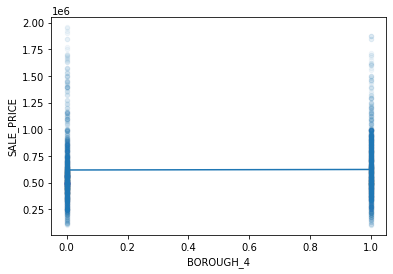

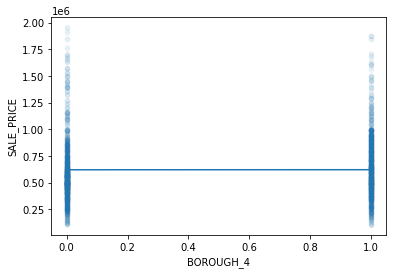

In [214]:
from sklearn.linear_model import RidgeCV
from IPython.display import display, HTML
from sklearn.linear_model import Ridge


# Try a range of alpha parameters for Ridge Regression.

# The scikit-learn docs explain, 
# alpha : Regularization strength; must be a positive float. Regularization 
# improves the conditioning of the problem and reduces the variance of the 
# estimates. Larger values specify stronger regularization.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
    
    # Fit Ridge Regression model
    feature = 'BOROUGH_4'
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train[[feature]], y_train)
    
    # Get Test MAE
    y_pred = model.predict(X_test[[feature]])
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    train.plot.scatter(feature, target, alpha=0.05)
    plt.plot(X_test[feature], y_pred)
    plt.show()